# Merge sort

This implements a parallel [merge sort](https://en.wikipedia.org/wiki/Merge_sort) using `DataFlowTasks`

## Sequential version

We'll use a "bottom-up" implementation of the merge sort algorithm. To explain
how it works, let's consider a small vector of 32 elements:

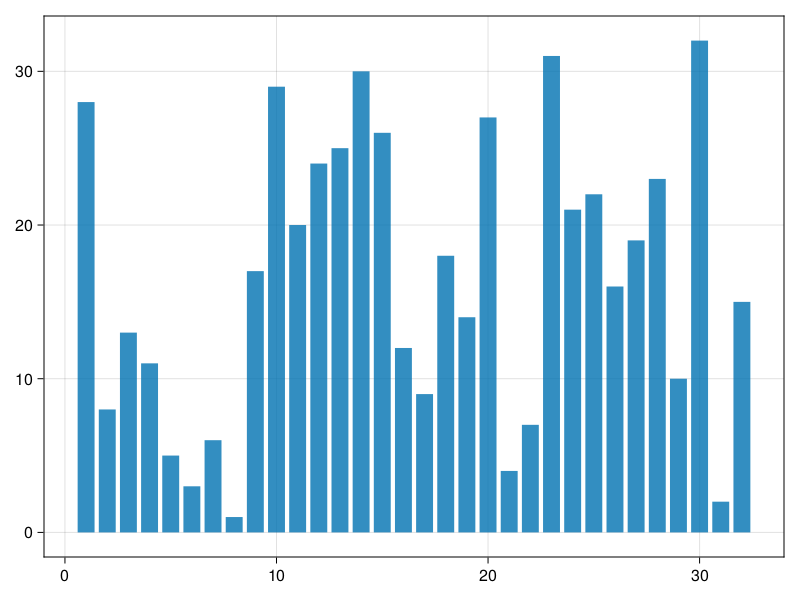

In [1]:
using Random, CairoMakie, CairoMakie.Colors
v = randperm(32)
barplot(v)

We decompose it into 4 blocks of 8 elements, which we sort individually:

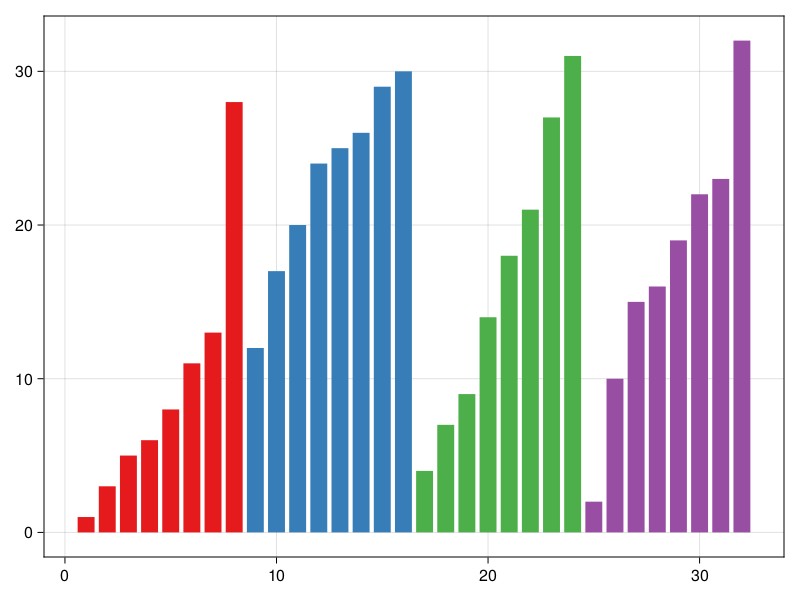

In [2]:
sort!(view(v, 1:8))
sort!(view(v, 9:16))
sort!(view(v, 17:24))
sort!(view(v, 25:32))
barplot(v; color=ceil.(Int, eachindex(v)./8), colormap=:Set1_4)

Now we can merge the first two 8-element blocks into a sorted 16-element
block. And do the same for the 3rd and 4th 8-element blocks. We'll need an
auxilliary array `w` to store the results:

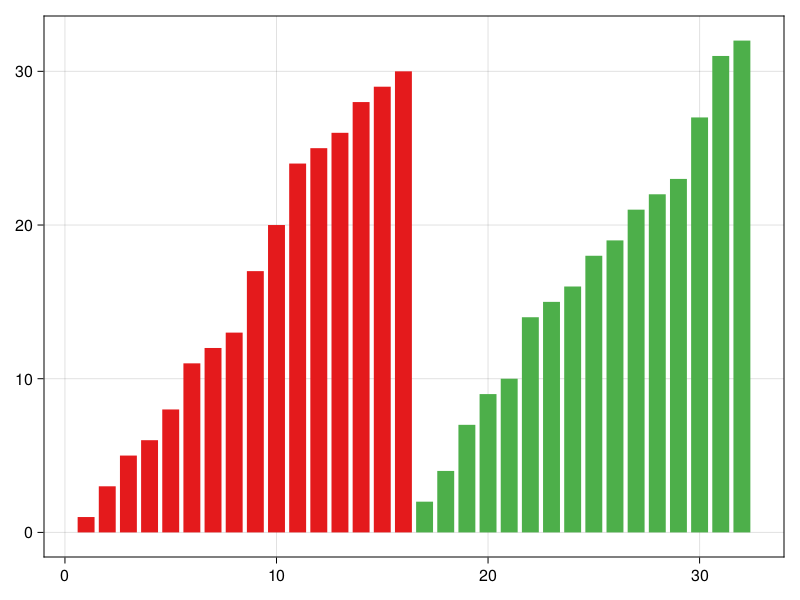

In [3]:
function merge!(dest, left, right)
    # pre-condition:
    #   `left`  is sorted
    #   `right` is sorted
    #   length(left) + length(right) == length(dest)
    # post-condition:
    #   dest is sorted

    (i, j) = (1, 1)
    (I, J) = (length(left), length(right))
    @assert I + J == length(dest)
    @inbounds for k in eachindex(dest)
        if i <= I && (j > J || left[i] < right[j])
            dest[k] = left[i]; i += 1
        else
            dest[k] = right[j]; j+=1
        end
    end
end

w = similar(v)
@views merge!(w[1:16],  v[1:8],   v[9:16])
@views merge!(w[17:32], v[17:24], v[25:32])
barplot(w; color=ceil.(Int, eachindex(v)./16), colormap=:Set1_3)

Now `w` is sorted in two blocks, which we can merge to get the entire sorted
array. Instead of using a new buffer to store the results, let's re-use the
original array `v`:

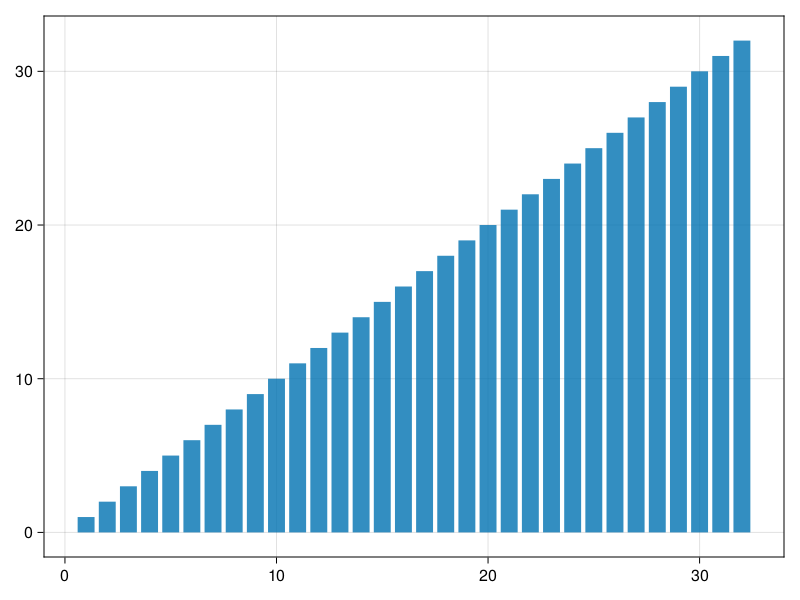

In [4]:
@views merge!(v, w[1:16], w[17:32])
barplot(v)

The following sequential implementation automates these steps.

First, the vector is decomposed in blocks of size 64 (by default). Each block is
sorted using an insertion sort (which works in-place without allocating
anything, and is relatively fast for small vectors).

Then, sorted blocks are grouped in pairs which are merged into the buffer. If
the number of blocks is odd, the last block is copied directly to the
destination buffer.

The auxiliary buffer is now composed of sorted blocks twice as large as the
original blocks, so we can iterate the algorithm with a doubled block size,
this time putting the results back to the original vector.

Depending on the parity of the number of iterations, the final result ends up
being stored either in the original vector (which is what we want) or in the
auxiliary buffer (in which case we copy it back to the original vector). The
semantics of `mergesort!` is thus that of an in-place sort: after the call,
`v` should be sorted.

In [5]:
function mergesort!(v, buf=similar(v), bs=64)
    N = length(v)

    for i₀ in 1:bs:N
        i₁ = min(i₀+bs-1, N)
        sort!(view(v, i₀:i₁), alg=InsertionSort)
    end

    (from, to) = (v, buf)

    while bs < length(v)
        i₀ = 1
        while i₀ < N
            i₁ = i₀+bs; i₁>N && break
            i₂ = min(i₀+2bs-1, N)
            @views merge!(to[i₀:i₂], from[i₀:i₁-1], from[i₁:i₂])

            i₀ = i₂+1
        end
        if i₀ <= N
            @inbounds @views to[i₀:N] .= from[i₀:N]
        end

        bs *= 2
        (from, to) = (to, from)
    end

    v === from || copy!(v, from)
    v
end

N = 100_000
v = rand(N)
buf = similar(v)

@assert mergesort!(copy(v), buf) == sort(v)

## Parallel version

Parallelizing with DataFlowTasks involves splitting the work into several
parallel tasks, which have to be annotated to list their data dependencies. In our case:

- Sorting each initial block involves calling the sequential implementation on
  it. The block size is larger here, to avoid spawning tasks for too small
  chunks. Each such task modifies its own block in-place.

- Merging two blocks (or copying a lone block) reads part of the source array, and writes to (the same)
  part of the destination array.

- A final task reads the whole array to act as a barrier: we can fetch it to
  synchronize all other tasks and get the result.

In [6]:
using DataFlowTasks

function mergesort_dft!(v, buf=similar(v), bs=16384)
    N = length(v)

    for i₀ in 1:bs:N
        i₁ = min(i₀+bs-1, N)
        DataFlowTasks.@spawn mergesort!(@RW(view(v, i₀:i₁))) label="sort\n$i₀:$i₁"
    end

    # WARNING: (from, to) are not local to each task
    (from, to) = (v, buf)

    while bs < N
        i₀ = 1  # WARNING: i is not local to each task
        while i₀ < N
            i₁ = i₀+bs; i₁>N && break
            i₂ = min(i₀+2bs-1, N)
            let
                left  = @view from[i₀:i₁-1]
                right = @view from[i₁:i₂]
                dest  = @view to[i₀:i₂]
                DataFlowTasks.@spawn merge!(@W(dest), @R(left), @R(right)) label="merge\n$i₀:$i₂"
            end
            i₀ = i₂+1
        end
        if i₀ <= N
            let
                src  = @view from[i₀:N]
                dest = @view to[i₀:N]
                DataFlowTasks.@spawn @W(dest) .= @R(src) label="copy\n$i₀:$N"
            end
        end

        bs *= 2
        (from, to) = (to, from)
    end

    final_task = DataFlowTasks.@spawn @R(from) label="result"
    fetch(final_task)
    v === from || copy!(v, from)
    v
end

@assert mergesort_dft!(copy(v), buf) == sort(v)

Task graph

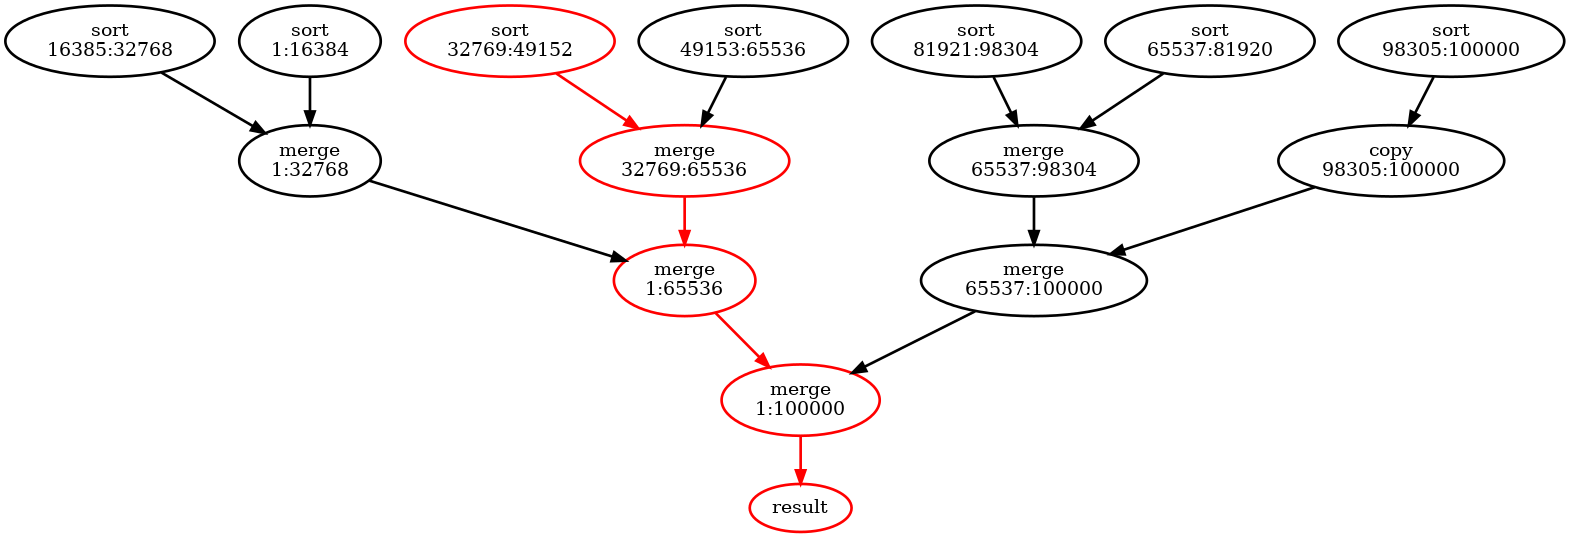

In [7]:
resize!(DataFlowTasks.get_active_taskgraph(), 2000)
log_info = DataFlowTasks.@log mergesort_dft!(copy(v))

using GraphViz
dag = GraphViz.Graph(log_info)

## Performance

In [8]:
N = 1_000_000
v = rand(N);
buf = similar(v);

using BenchmarkTools
bench_seq = @benchmark mergesort!(x, $buf) setup=(x=copy(v)) evals=1

BenchmarkTools.Trial: 7 samples with 1 evaluation.
 Range (min … max):  134.719 ms … 137.940 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     135.232 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   135.975 ms ±   1.239 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █    █  ██                            █    █                █  
  █▁▁▁▁█▁▁██▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  135 ms           Histogram: frequency by time          138 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [9]:
bench_dft = @benchmark mergesort_dft!(x, $buf) setup=(x=copy(v)) evals=1

BenchmarkTools.Trial: 19 samples with 1 evaluation.
 Range (min … max):  41.661 ms … 52.856 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     43.418 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   44.577 ms ±  2.909 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █                                                            
  █▇▇▁▁▇▇▇▇▇▁▁▁▁▁▇▇▁▁▁▇▇▁▁▁▇▁▇▁▁▇▁▁▁▁▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▇ ▁
  41.7 ms         Histogram: frequency by time        52.9 ms <

 Memory estimate: 7.97 MiB, allocs estimate: 4882.

In [10]:
(;
 nthreads = Threads.nthreads(),
 speedup = time(minimum(bench_seq)) / time(minimum(bench_dft)))

(nthreads = 8, speedup = 3.2336951509769274)

In [11]:
log_info = DataFlowTasks.@log mergesort_dft!(copy(v))
DataFlowTasks.describe(log_info, categories=["sort", "merge", "copy", "result"])

• Elapsed time           : 0.048
  ├─ Critical path       : 0.027
  ╰─ No-wait             : 0.032

• Run time               : 0.386
  ├─ Computing           :   0.258
  │  ├─ sort             :     0.189
  │  ├─ merge            :     0.069
  │  ├─ copy             :     0.000
  │  ├─ result           :     0.000
  │  ╰─ unlabeled        :     0.000
  ├─ Task insertion      :   0.000
  ╰─ Other (waiting)     :   0.128

[ Info: Computing    : 0.25756764599999993
[ Info: Inserting    : 0.0004907429999999999
[ Info: Other        : 0.12786513818114853


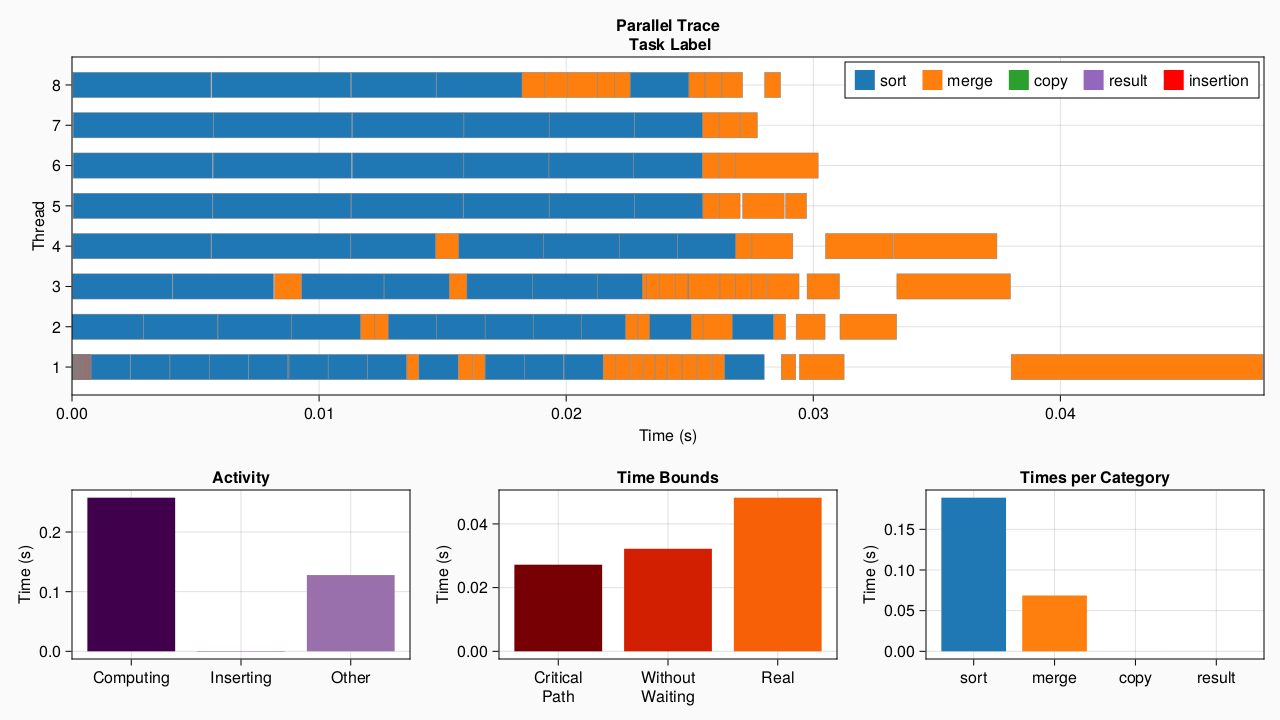

In [12]:
using CairoMakie
plot(log_info, categories=["sort", "merge", "copy", "result"])

In [13]:
function tiled_merge!(dest, left, right)
    function split_indices(dest, left, right)
        (I, J, K) = length(left), length(right), length(dest)
        @assert I+J == K

        i = 1 + I ÷ 2
        pivot = left[i-1]
        j = findfirst(>(pivot), right)
        k = i + j - 1

        [(1:i-1, 1:j-1, 1:k-1),
         (i:I,   j:J,   k:K)]
    end

    (rᵢ, rⱼ, rₖ) = split_indices(dest, left, right)[1]
    @views merge!(dest[rₖ], left[rᵢ], right[rⱼ])

    (rᵢ, rⱼ, rₖ) = split_indices(dest, left, right)[2]
    @views merge!(dest[rₖ], left[rᵢ], right[rⱼ])
end


function split_indices(N, dest, left, right)
    (I, J, K) = length(left), length(right), length(dest)
    @assert I+J == K

    i = ones(Int, N+1)
    j = ones(Int, N+1)
    k = ones(Int, N+1)
    for p in 2:N
        i[p] = 1 + ((p-1)*I) ÷ N
        j[p] = findfirst(>(left[i[p]-1]), right)
        k[p] = k[p-1] + i[p]-i[p-1] + j[p]-j[p-1]
    end
    i[N+1] = I+1; j[N+1] = J+1; k[N+1] = K+1

    map(1:N) do p
        (i[p]:i[p+1]-1, j[p]:j[p+1]-1, k[p]:k[p+1]-1)
    end
end

function tiled_merge_dft!(dest, left, right; label="")
    if length(dest) < 100_000
        DataFlowTasks.@spawn merge!(@W(dest), @R(left), @R(right)) label=label
        return
    end

    N = 4

    k = round.(Int, LinRange(1, length(dest)+1, N+1))
    for p in 1:N
        piece = 'A' + p -1
        destₚ = @view dest[k[p]:k[p+1]-1]

        DataFlowTasks.@spawn let
            @R left
            @R right
            @W destₚ

            (rᵢ, rⱼ, rₖ) = split_indices(N, dest, left, right)[p]
            @views merge!(dest[rₖ], left[rᵢ], right[rⱼ])
        end label="$label $piece"
    end
end


function mergesort_dft_tiled!(v, buf=similar(v), bs=16384)
    N = length(v)

    for i₀ in 1:bs:N
        i₁ = min(i₀+bs-1, N)
        DataFlowTasks.@spawn mergesort!(@RW(view(v, i₀:i₁))) label="sort\n$i₀:$i₁"
    end

    (from, to) = (v, buf)

    while bs < N
        i₀ = 1
        while i₀ < N
            i₁ = i₀+bs; i₁>N && break
            i₂ = min(i₀+2bs-1, N)
            let
                left  = @view from[i₀:i₁-1]
                right = @view from[i₁:i₂]
                dest  = @view to[i₀:i₂]
                tiled_merge_dft!(dest, left, right, label="merge\n$i₀:$i₂")
            end
            i₀ = i₂+1
        end
        if i₀ <= N
            let
                src  = @view from[i₀:N]
                dest = @view to[i₀:N]
                DataFlowTasks.@spawn @W(dest) .= @R(src) label="copy\n$i₀:$N"
            end
        end

        bs *= 2
        (from, to) = (to, from)
    end

    final_task = DataFlowTasks.@spawn @R(from) label="result"
    fetch(final_task)
    v === from || copy!(v, from)
    v
end

@assert mergesort_dft_tiled!(copy(v), buf) == sort(v)
bench_dft2 = @benchmark mergesort_dft_tiled!(x, $buf) setup=(x=copy(v)) evals=1

BenchmarkTools.Trial: 27 samples with 1 evaluation.
 Range (min … max):  23.320 ms … 41.516 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     31.534 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   31.368 ms ±  3.737 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

                       ▄  ▄  ▁▁█ ▁                             
  ▆▁▁▁▁▁▁▆▁▁▆▁▆▁▁▁▁▁▆▁▁█▁▆█▆▆███▁█▆▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▆▆ ▁
  23.3 ms         Histogram: frequency by time        41.5 ms <

 Memory estimate: 8.07 MiB, allocs estimate: 6010.

In [14]:
(;
 nthreads = Threads.nthreads(),
 speedup = time(minimum(bench_seq)) / time(minimum(bench_dft2)))

(nthreads = 8, speedup = 5.777098514972108)

In [15]:
log_info = DataFlowTasks.@log mergesort_dft_tiled!(copy(v), buf)
DataFlowTasks.describe(log_info, categories=["sort", "merge", "copy", "result"])

• Elapsed time           : 0.036
  ├─ Critical path       : 0.015
  ╰─ No-wait             : 0.033

• Run time               : 0.290
  ├─ Computing           :   0.263
  │  ├─ sort             :     0.183
  │  ├─ merge            :     0.080
  │  ├─ copy             :     0.000
  │  ├─ result           :     0.000
  │  ╰─ unlabeled        :     0.000
  ├─ Task insertion      :   0.001
  ╰─ Other (waiting)     :   0.026

[ Info: Computing    : 0.2630824650000001
[ Info: Inserting    : 0.0008958600000000003
[ Info: Other        : 0.025683602148699736


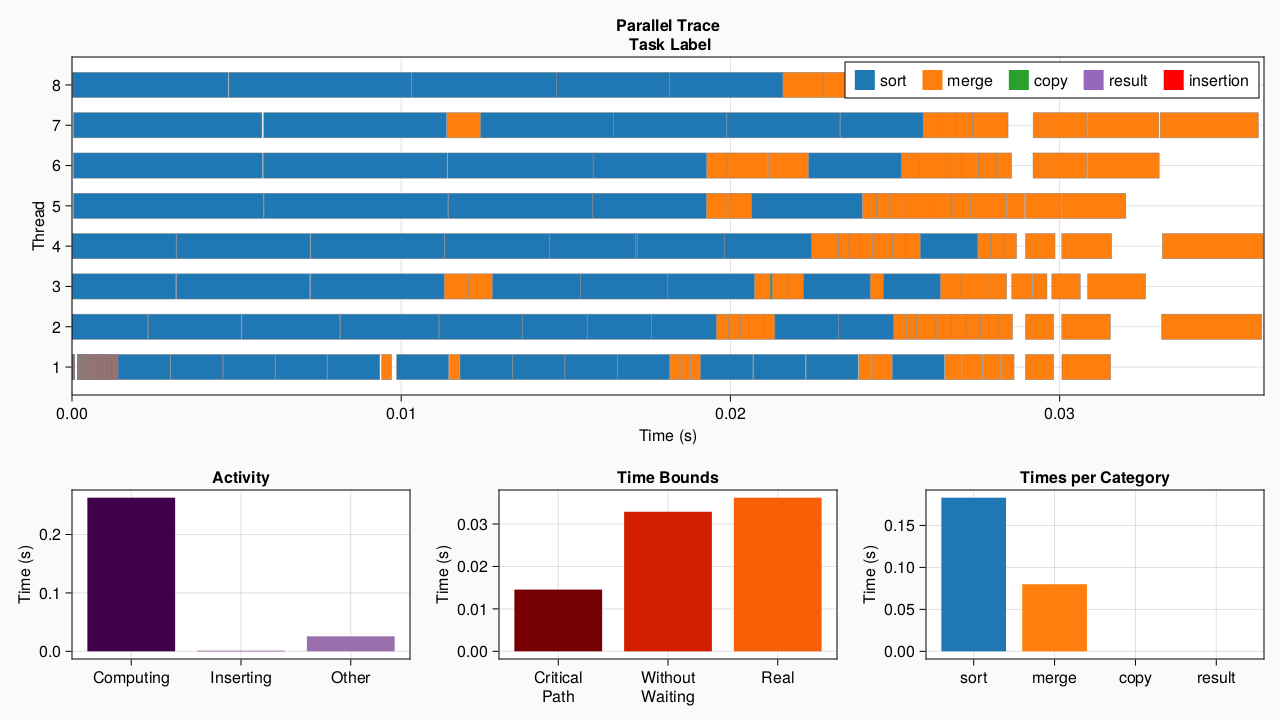

In [16]:
plot(log_info, categories=["sort", "merge", "copy", "result"])

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*